### Do your imports!

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
# in the place of the 'None,' you can put a number to only show 3 columns or 10 columns
# 'None' means no limit / show all columns

/Users/ilenapeng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# 311 data analysis

## Read in `subset.csv` and review the first few rows

Even though it's a giant file – gigs and gigs! – it's a subset of the [entire dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9). It covers plenty of years, but not all of the columns.

If your computer is struggling (which it will!) or you are impatient, feel free to use `nrows=` when reading it in to speed up the process by only reading in a subset of columns. Pull in at least a few million, or a couple years back.

In [2]:
df = pd.read_csv('subset.csv', nrows=500000)
# df.sample takes longer because it reads all your data and then takes a sample
# but df.sample allows you to select only 50% of my data OR specific rows
# excel files, you can't do nrows, it'll read the whole thing

# you can't tell pandas to say 'give me a random subset from this data, but don't read the whole file first'
# if something was way too big to open here, you would open it in SQL and then ask them to give you a random subset
# from 30 million rows

/Users/ilenapeng/.pyenv/versions/3.9.7/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head(5)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Address Type,City,Status,Borough,Open Data Channel Type
0,41694420,01/27/2019 07:26:21 PM,02/13/2019 10:53:25 AM,HPD,Department of Housing Preservation and Develop...,GENERAL,BELL/BUZZER/INTERCOM,RESIDENTIAL BUILDING,11216,30 MAC DONOUGH STREET,ADDRESS,BROOKLYN,Closed,BROOKLYN,PHONE
1,41694421,01/29/2019 11:06:56 AM,02/13/2019 02:07:22 AM,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10453,30 RICHMAN PLAZA,ADDRESS,BRONX,Closed,BRONX,PHONE
2,41694422,02/13/2019 12:28:18 PM,03/15/2019 09:54:50 AM,DOF,External Affairs Unit,DOF Property - Payment Issue,Bill Received in Error,Property Address,11412,120-25 200 STREET,ADDRESS,SAINT ALBANS,Closed,QUEENS,PHONE
3,41694423,02/13/2019 03:40:19 PM,02/20/2019 06:18:35 AM,DOT,Department of Transportation,Broken Parking Meter,Out of Order,Street,11377,NaN,INTERSECTION,WOODSIDE,Closed,QUEENS,PHONE
4,41694424,02/13/2019 01:18:31 PM,02/20/2019 05:36:54 AM,DOT,Department of Transportation,Broken Parking Meter,Out of Order,Street,10461,1082 MORRIS PARK AVENUE,ADDRESS,BRONX,Closed,BRONX,PHONE


### Where the subset came from

If you're curious, I took the [original data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data) and clipped out a subset by using the command-line tool [csvkit](https://csvkit.readthedocs.io/en/latest/).

First I inspected the column headers:

```bash
$ csvcut -n 311_Service_Requests_from_2010_to_Present.csv 
```

Then I selected the columns I was interested in and saved it to a file.

```bash
$ csvcut -c 1,2,3,4,5,6,7,8,9,10,16,17,20,26,29 311_Service_Requests_from_2010_to_Present.csv > subset.csv
```

This was much much much much faster than doing it in Python.

## We want more columns!

**Right now we don't see all of the columns.** For example, mine has `...` between the **Incident Address** column and the **City** column. Go up to the top where you imported pandas, and add a `pd.set_option` line that will allow you to view all of the columns of the dataset.

## We hate those column names!

Change the column names to be tab- and period-friendly, like `df.created_date` instead of `df['Created Date']`

In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'address_type', 'city', 'status', 'borough',
       'open_data_channel_type'],
      dtype='object')

# Dates and times

## Are the datetimes actually datetimes?

We're going to be doing some datetime-y things, so let's see if the columns that look like dates are actually dates.

In [5]:
df.dtypes

unique_key                 int64
created_date              object
closed_date               object
agency                    object
agency_name               object
complaint_type            object
descriptor                object
location_type             object
incident_zip              object
incident_address          object
address_type              object
city                      object
status                    object
borough                   object
open_data_channel_type    object
dtype: object

## In they aren't datetimes, convert them

The ones we're interested in are as follows:

* Created Date
* Closed Date

You have two options to convert them:

1. Do it like we did in class, but **overwrite the existing string columns with the new datetime versions**
2. Find an option with `read_csv` to automatically read certain columns as dates! Use the shift+tab trick to read the `read_csv` docs to uncover it. Once you find it, you'll set it to be the **list of date-y columns**.

They're both going to take forever if you do them wrong, but can be faster with a few tricks. For example, using `pd.to_datetime` can be sped up significantly be specifying the format of the datestring.

For example, if your datetime was formatted as `YYYY-MM-DD HH:MM:SS AM`, you could use the following:

```
df.my_datetime = pd.to_datetime(df.my_datetime, format="%Y-%m-%d %I:%M:%S %p")
```

It's unfortunately much much much faster than the `read_csv` technique. And yes, [that's `%I` and not `%H`](https://strftime.org/).

> *Tip: What should happen if it encounters an error or missing data?*

In [6]:
df.created_date = pd.to_datetime(df.created_date, format="%m/%d/%Y %I:%M:%S %p")
# specifying format is a lot faster on your computer than not specifying it
# but sometimes pd.to_datetime doesn't work with any format that you put
# %I is 12-hour clock. %H is 24-hour clock

## ALSO TO NOTE: adding %%time to the beginning of any cell will tell you how long it takes to run

In [7]:
df.closed_date = pd.to_datetime(df.closed_date, format="%m/%d/%Y %I:%M:%S %p")

In [8]:
df.dtypes

unique_key                         int64
created_date              datetime64[ns]
closed_date               datetime64[ns]
agency                            object
agency_name                       object
complaint_type                    object
descriptor                        object
location_type                     object
incident_zip                      object
incident_address                  object
address_type                      object
city                              object
status                            object
borough                           object
open_data_channel_type            object
dtype: object

## According to the dataset, which month of the year has the most 311 calls?

The kind of answer we're looking for is "January," not "January 2021"

In [9]:
df.created_date.dt.strftime('%m').value_counts()

03    199264
04    166461
02    105466
01     12451
12      4662
11      1866
10      1832
08      1782
09      1738
07      1692
06      1424
05      1362
Name: created_date, dtype: int64

In [10]:
# CORRECT ANSWER
# strftime can't be plotted because it'll plot out of order (it turns everything to a string)
df.created_date.dt.month.value_counts()

3     199264
4     166461
2     105466
1      12451
12      4662
11      1866
10      1832
8       1782
9       1738
7       1692
6       1424
5       1362
Name: created_date, dtype: int64

In [11]:
# To get the month name, if you really wanted it
df.created_date.dt.strftime('%B').value_counts()

March        199264
April        166461
February     105466
January       12451
December       4662
November       1866
October        1832
August         1782
September      1738
July           1692
June           1424
May            1362
Name: created_date, dtype: int64

In [12]:
# Another way to get the month name
df.created_date.dt.month_name().value_counts()

March        199264
April        166461
February     105466
January       12451
December       4662
November       1866
October        1832
August         1782
September      1738
July           1692
June           1424
May            1362
Name: created_date, dtype: int64

In [13]:
# .dt -- every single January is combined into a super-January
# .resample -- each year's January is SEPARATE

## According to the dataset, which month has had the most 311 calls?

The kind of answer we're looking for is "January 2021," not "January" (although _techniucally_ it will say `2021-01-31`, not `January 2021`)

In [14]:
df['month_year'] = df.created_date.dt.strftime('%y-%m')
df.month_year.value_counts().head(5)

19-03    197975
19-04    165207
19-02    104099
19-01     10797
18-12      4051
Name: month_year, dtype: int64

In [15]:
# CORRECT ANSWER: uses resample
# resample = groupby of time
# resample has to use size, you can't use value_counts()
# M - group by month, on = the variable to look at
df.resample('M', on='created_date').size().sort_values(ascending=False)

created_date
2019-03-31    197975
2019-04-30    165207
2019-02-28    104099
2019-01-31     10797
2018-12-31      4051
               ...  
2011-01-31         2
2010-10-31         1
2010-09-30         1
2012-03-31         1
2010-08-31         1
Length: 105, dtype: int64

## Plot the 311 call frequency over our dataset on a _weekly_ basis

To make your y axis start at zero, use `ylim=(0,100000)` when doing `.plot`. But replace the `1000` with a large enough value to actually see your data nicely!

<AxesSubplot:>

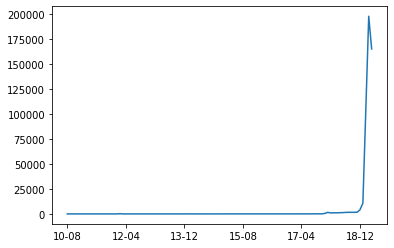

In [16]:
# This is WRONG, I accidentally did this monthly instead of weekly
df.month_year.value_counts().sort_index().plot()
# my chart already started from 0! so I didn't use ylim here

<AxesSubplot:xlabel='created_date'>

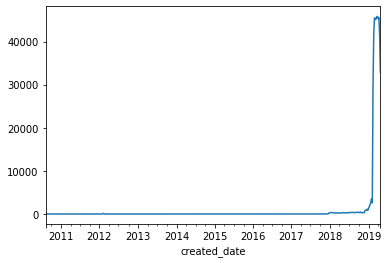

In [17]:
# CORRECT ANSWER:
df.resample('W', on='created_date').size().plot()

## What time of day (by hour) is the most least for 311 complains? The most common?


In [18]:
df.created_date.dt.strftime('%I %p').value_counts()

11 AM    34489
10 AM    34202
09 AM    32768
12 PM    32677
01 PM    30788
02 PM    30716
03 PM    29716
04 PM    27935
08 AM    24909
05 PM    23284
06 PM    21734
09 PM    21244
10 PM    21082
08 PM    20813
07 PM    20721
12 AM    20243
11 PM    18288
07 AM    15453
01 AM     9881
06 AM     9108
02 AM     5995
05 AM     5140
03 AM     4649
04 AM     4165
Name: created_date, dtype: int64

In [19]:
# CORRECT ANSWER:
df.created_date.dt.hour.value_counts().sort_index()

0     20243
1      9881
2      5995
3      4649
4      4165
5      5140
6      9108
7     15453
8     24909
9     32768
10    34202
11    34489
12    32677
13    30788
14    30716
15    29716
16    27935
17    23284
18    21734
19    20721
20    20813
21    21244
22    21082
23    18288
Name: created_date, dtype: int64

### Make a graph of the results

* Make sure the hours are in the correct order
* Be sure to set the y-axis to start at 0
* Give your plot a descriptive title

<AxesSubplot:title={'center':'NY 311 Calls Per Hour'}>

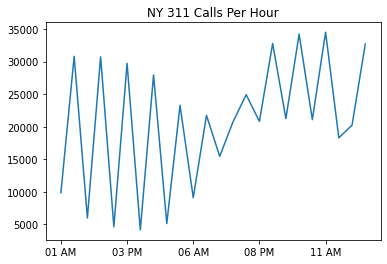

In [20]:
df.created_date.dt.strftime('%I %p').value_counts().sort_index().plot(title='NY 311 Calls Per Hour')

<AxesSubplot:title={'center':'NY 311 Calls Per Hour'}>

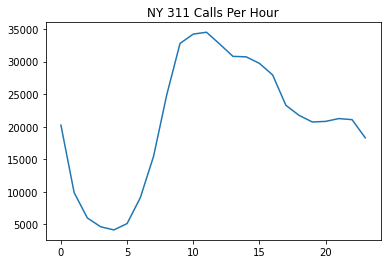

In [21]:
# CORRECT ANSWER:
df.created_date.dt.hour.value_counts().sort_index().plot(title='NY 311 Calls Per Hour')

# Agencies

## What agencies field the most complaints in the dataset? Get the top 5.

Use the `agency` column for this one.

In [22]:
df.agency.value_counts().head(5)

NYPD    143417
HPD     132810
DSNY     70815
DOT      54411
DOB      38580
Name: agency, dtype: int64

## What are each of those agencies?

Define the following five acronyms:

* NYPD
* HPD
* DOT
* DSNY
* DEP

In [23]:
df.agency_name.value_counts().head(6)

# NYPD - New York City Police Department
# HPD - Department of Housing Preservation and Development
# DOT - Department of Transportation
# DSNY - Department of Sanitation
# DEP - Department of Environmental Protection

New York City Police Department                       143125
Department of Housing Preservation and Development    132806
Department of Transportation                           54411
Department of Sanitation                               46261
Department of Buildings                                38580
Department of Environmental Protection                 32938
Name: agency_name, dtype: int64

## What is the most common complaint to HPD?

In [24]:
df[df.agency == 'HPD'].complaint_type.value_counts().head(5)

HEAT/HOT WATER          48100
UNSANITARY CONDITION    17789
PAINT/PLASTER           13495
PLUMBING                12494
DOOR/WINDOW              9050
Name: complaint_type, dtype: int64

## What are the top 3 complaints to each agency?

You'll want to use the weird confusing `.groupby(level=...` thing we learned when reviewing the homework.

In [25]:
df.groupby('agency').complaint_type.value_counts().groupby(level=0).head(3)

# he prefers nlargest, but they're the same
# df.groupby('agency').complaint_type.value_counts().groupby(level=0, group_keys=False).nlargest(3)

agency  complaint_type                     
ACS     Forms                                     69
COIB    Forms                                      2
DCA     Consumer Complaint                      2855
DCAS    Question                                 162
        Comments                                  11
DCP     Research Questions                         4
DEP     Noise                                  12680
        Water System                            9467
        Sewer                                   5355
DFTA    Housing - Low Income Senior             1135
        Housing Options                          342
        Senior Center Complaint                   43
DHS     Homeless Person Assistance               385
DOB     Elevator                               19489
        General Construction/Plumbing           6829
        Building/Use                            4156
DOE     School Maintenance                       238
DOF     DOF Property - Payment Issue            1367
  

## What is the most common kind of residential noise complaint?

The NYPD seems to deal with a lot of noise complaints at homes. What is the most common subtype?

In [26]:
df[(df.agency=='NYPD') & (df.complaint_type=='Noise - Residential')].descriptor.value_counts()

Loud Music/Party    24808
Banging/Pounding    13880
Loud Talking         3016
Loud Television       985
Name: descriptor, dtype: int64

## What time of day do "Loud Music/Party" complaints come in? Make it a chart!

In [27]:
df[(df.agency=='NYPD') & (df.complaint_type=='Noise - Residential') & (df.descriptor == 'Loud Music/Party')]. \
created_date.dt.strftime('%I %p').value_counts()

11 PM    3252
12 AM    3139
10 PM    3001
01 AM    2068
09 PM    1942
08 PM    1470
07 PM    1183
02 AM    1180
06 PM     929
03 AM     822
05 PM     755
04 PM     694
03 PM     605
01 PM     526
02 PM     505
04 AM     501
12 PM     431
11 AM     374
05 AM     345
10 AM     252
09 AM     242
06 AM     220
08 AM     198
07 AM     174
Name: created_date, dtype: int64

In [28]:
# CORRECT ANSWER:
df[(df.agency=='NYPD') & (df.complaint_type=='Noise - Residential') & (df.descriptor == 'Loud Music/Party')] \
.created_date.dt.hour.value_counts().sort_index()

0     3139
1     2068
2     1180
3      822
4      501
5      345
6      220
7      174
8      198
9      242
10     252
11     374
12     431
13     526
14     505
15     605
16     694
17     755
18     929
19    1183
20    1470
21    1942
22    3001
23    3252
Name: created_date, dtype: int64

## When do people party hard?

Make a monthly chart of Loud Music/Party complaints since the beginning of the dataset. Make it count them on a biweekly basis (every two weeks).

<AxesSubplot:xlabel='created_date'>

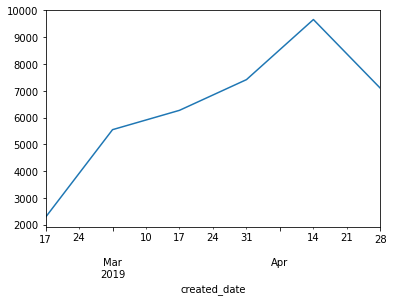

In [29]:
df[df.descriptor == 'Loud Music/Party'].resample('2W', on='created_date').size().plot()

## People and their bees

Sometimes people complain about bees! Why they'd do that, I have no idea. It's somewhere in "complaint_type" – can you find all of the bee-related complaints?

In [30]:
# Used this to figure out where the bee complaints were:
# df.complaint_type.unique()
df[df.complaint_type.str.contains("Bee")]

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,month_year
288065,42054326,2019-03-26 19:10:34,2019-04-05 15:00:55,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Beekeeping - Honeybees,1-2 Family Dwelling,11103.0,24-19 42 STREET,ADDRESS,ASTORIA,Closed,QUEENS,PHONE,19-03
291446,42058804,2019-03-26 18:14:03,2019-04-05 15:02:00,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Beekeeping - Honeybees,1-2 Family Dwelling,11104.0,42-19 42 STREET,ADDRESS,SUNNYSIDE,Closed,QUEENS,PHONE,19-03
372834,42163934,2019-04-08 18:26:04,2019-04-29 11:18:17,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Dwelling,10302,57 HOOKER PLACE,ADDRESS,STATEN ISLAND,Closed,STATEN ISLAND,PHONE,19-04
378505,42171504,2019-04-08 15:50:40,2019-04-29 11:11:42,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Mixed Use Building,11214,2060 78 STREET,ADDRESS,BROOKLYN,Closed,BROOKLYN,ONLINE,19-04
391645,42189666,2019-04-10 19:28:14,2019-04-29 11:17:09,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Beekeeping - Honeybees,1-2 Family Dwelling,10469,1462 STICKNEY PLACE,ADDRESS,BRONX,Closed,BRONX,PHONE,19-04
466469,42291921,2019-04-23 11:39:59,2019-05-06 09:36:28,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,1-2 Family Dwelling,11210,674 EAST 22 STREET,ADDRESS,BROOKLYN,Closed,BROOKLYN,PHONE,19-04
472431,42300656,2019-04-23 14:56:21,2019-05-06 09:37:30,DOHMH,Department of Health and Mental Hygiene,Harboring Bees/Wasps,Bees/Wasps - Not a beekeper,3+ Family Apartment Building,10037,2311 5 AVENUE,ADDRESS,NEW YORK,Closed,MANHATTAN,PHONE,19-04


### What month do most of the complaints happen in? I'd like to see a graph.

<AxesSubplot:>

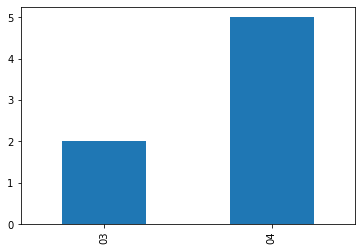

In [31]:
df[df.complaint_type.str.contains("Bee")].created_date.dt.strftime('%m').value_counts().sort_index().plot(kind='bar')

### Are the people getting in trouble usually beekeepers or not beekeepers?

In [32]:
df[df.complaint_type=='Harboring Bees/Wasps'].descriptor.value_counts()

Bees/Wasps - Not a beekeper    4
Beekeeping - Honeybees         3
Name: descriptor, dtype: int64

# Math with datetimes

## How long does it normally take to resolve a 311 complaint?

Even if we didn't cover this in class, I have faith that you can guess how to calculate it.

In [33]:
df.closed_date - df.created_date

0        16 days 15:27:04
1        14 days 15:00:26
2        29 days 21:26:32
3         6 days 14:38:16
4         6 days 16:18:23
               ...       
499995    2 days 21:57:58
499996    2 days 17:09:26
499997    3 days 03:51:50
499998    1 days 01:16:03
499999    2 days 04:59:44
Length: 500000, dtype: timedelta64[ns]

Save it as a new column called `time_to_fix`

In [34]:
df['time_to_fix'] = df.closed_date - df.created_date

## Which agency has the best time-to-fix time?

In [35]:
df.groupby('agency').time_to_fix.mean().sort_values()
# better answer would be median

agency
DHS      0 days 03:15:55.379220779
NYPD     0 days 04:25:51.774747763
DSNY     4 days 11:40:07.711909204
DEP      4 days 17:33:17.511784823
DOT      6 days 13:23:32.788485375
DOE      7 days 21:48:19.260504201
DCA      8 days 17:38:53.481260945
DPR     11 days 06:06:50.193993610
DFTA    11 days 20:52:59.579701120
DOHMH   12 days 10:30:35.071569487
HPD     14 days 08:31:36.037208776
DOITT   15 days 12:09:28.047619047
DOF     16 days 23:45:41.472046413
EDC     21 days 03:14:54.952702702
TLC     49 days 10:55:49.767542140
DOB     56 days 15:36:24.891705547
ACS                            NaT
COIB                           NaT
DCAS                           NaT
DCP                            NaT
TAX                            NaT
Name: time_to_fix, dtype: timedelta64[ns]

In [36]:
# Better answer would've used median
df.groupby('agency').time_to_fix.median().sort_values()

agency
DHS             0 days 01:16:59
NYPD            0 days 02:33:24
DEP             0 days 23:21:00
DOT             1 days 08:14:38
DSNY            2 days 09:55:00
DPR             2 days 23:40:03
DOHMH           3 days 00:30:35
DOE      4 days 01:09:43.500000
HPD             5 days 10:30:19
DOF            12 days 21:59:10
DFTA    12 days 23:45:25.500000
DOITT          14 days 17:30:55
DCA            15 days 01:44:13
DOB     18 days 11:27:22.500000
EDC            19 days 00:41:53
TLC            58 days 23:03:53
ACS                         NaT
COIB                        NaT
DCAS                        NaT
DCP                         NaT
TAX                         NaT
Name: time_to_fix, dtype: timedelta64[ns]

## Maybe we need some more information...

I might want to know how big our sample size is for each of those, maybe the high performers only have one or two instances of having requests filed!

### First, try using `.describe()` on the time to fix column after your `groupby`.

In [37]:
df.groupby('agency').time_to_fix.describe()

,count,mean,std,min,25%,50%,75%,max
agency,,,,,,,,
ACS,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
COIB,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DCA,2855,8 days 17:38:53.481260945,6 days 21:29:59.577945279,0 days 00:24:01,1 days 07:19:21,15 days 01:44:13,15 days 11:08:52.500000,26 days 19:19:49
DCAS,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DCP,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DEP,32457,4 days 17:33:17.511784823,20 days 14:54:31.532085500,0 days 00:00:00,0 days 03:09:00,0 days 23:54:00,4 days 02:27:00,901 days 09:09:00
DFTA,1606,11 days 20:52:59.579701120,4 days 07:08:39.905979742,0 days 01:50:29,9 days 22:26:47,12 days 23:45:25.500000,14 days 04:24:16.250000,33 days 17:46:05
DHS,385,0 days 03:15:55.379220779,0 days 05:28:54.724780130,0 days 00:00:40,0 days 00:16:31,0 days 01:16:59,0 days 03:37:33,2 days 11:45:22
DOB,38580,56 days 15:36:24.891705547,175 days 15:50:36.222076966,0 days 00:00:00,3 days 10:48:47,18 days 11:27:22.500000,44 days 02:54:14.250000,3307 days 12:04:34


### Now, an alternative

Seems a little busy, yeah? **You can also do smaller, custom aggregations.**

Try something like this:

```python
# Multiple aggregations of one column
df.groupby('agency').time_to_fix.agg(['median', 'size'])

# You can also do something like this to reach multiple columns
df.groupby('agency').agg({
    'time_to_fix': ['median', 'size']
})
```

In [38]:
df.groupby('agency').time_to_fix.agg(['median', 'size'])

# also ran
# df.groupby('agency').time_to_fix.agg(['mean', 'size'])

,median,size
agency,,
ACS,NaT,69
COIB,NaT,2
DCA,15 days 01:44:13,2855
DCAS,NaT,173
DCP,NaT,4
DEP,0 days 23:21:00,32938
DFTA,12 days 23:45:25.500000,1606
DHS,0 days 01:16:59,385
DOB,18 days 11:27:22.500000,38580


## Seems weird that NYPD time-to-close is so fast. Can we break that down by complaint type?

Remember the order: 

1. Filter
2. Group
3. Grab a column
4. Do something with it
5. Sort

In [39]:
df[df.agency == 'NYPD'].groupby('complaint_type').time_to_fix.median().sort_values()
# also tried looking at mean:
# df[df.agency == 'NYPD'].groupby('complaint_type').time_to_fix.mean().sort_values()

complaint_type
Noise - Vehicle               0 days 01:34:31.500000
Noise - Park                         0 days 01:46:20
Traffic                              0 days 01:53:45
Noise - Commercial                   0 days 01:59:35
Noise - Street/Sidewalk              0 days 02:00:30
Bike/Roller/Skate Chronic            0 days 02:01:18
Noise - House of Worship             0 days 02:02:31
Drinking                             0 days 02:22:05
Non-Emergency Police Matter          0 days 02:24:57
Disorderly Youth                     0 days 02:25:35
Noise - Residential                  0 days 02:27:47
Vending                              0 days 02:34:18
Homeless Encampment           0 days 02:37:04.500000
Illegal Parking               0 days 02:42:50.500000
Posting Advertisement         0 days 02:46:26.500000
Panhandling                          0 days 02:53:57
Urinating in Public                  0 days 02:54:11
Blocked Driveway                     0 days 03:05:19
Animal Abuse                   

## Back to median fix time for all agencies: do these values change based on the borough?

First, use `groupby` to get the median time to fix per agency in each borough. You can use something like `pd.set_option("display.max_rows", 200)` if you can't see all of the results by default!

In [40]:
pd.set_option("display.max_rows", 200)
df.groupby(['borough', 'agency']).time_to_fix.median()

# to make this a df:
# df.groupby(['agency', 'borough']).time_to_fix.median().sort_values() \
#     .to_frame('median_time_to_fix').reset_index()

borough        agency
BRONX          DCA             15 days 06:21:21
               DEP              0 days 21:23:30
               DFTA     13 days 00:02:30.500000
               DHS       0 days 01:43:37.500000
               DOB             15 days 15:08:27
               DOE              5 days 01:34:55
               DOF             14 days 22:46:47
               DOHMH            2 days 00:00:00
               DOITT    15 days 01:18:20.500000
               DOT              1 days 00:56:15
               DPR              4 days 05:28:17
               DSNY             1 days 16:25:00
               EDC             29 days 09:57:57
               HPD              6 days 07:25:41
               NYPD             0 days 03:57:43
               TLC      55 days 17:23:51.500000
BROOKLYN       DCA              5 days 03:51:55
               DEP              0 days 19:56:00
               DFTA            12 days 23:30:09
               DHS       0 days 01:56:10.500000
               DOB

### Or, use another technique!

We talked about pivot table for a hot second in class, but it's (potentially) a good fit for this situation:

```python
df.pivot_table(
    columns='what will show up as your columns',
    index='what will show up as your rows',
    values='the column that will show up in each cell',
    aggfunc='the calculation(s) you want dont'
)
```

In [41]:
pivoted = df.pivot_table(
    columns='borough',
    index='agency',
    values='time_to_fix',
    aggfunc='median'
)

pivoted

# Another way I attempted this: with borough as the row and agency as the index
# df.pivot_table(
#     columns='agency',
#     index='borough',
#     values='time_to_fix',
#     aggfunc='median'
# )

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
agency,,,,,,
DCA,15 days 06:21:21,5 days 03:51:55,3 days 18:14:23,15 days 01:35:38,15 days 06:10:56,15 days 09:54:22
DEP,0 days 21:23:30,0 days 19:56:00,1 days 23:09:00,0 days 20:13:00,0 days 18:56:00,0 days 00:59:30
DFTA,13 days 00:02:30.500000,12 days 23:30:09,12 days 22:24:04.500000,13 days 02:33:22.500000,13 days 23:36:06,8 days 01:03:31
DHS,0 days 01:43:37.500000,0 days 01:56:10.500000,0 days 01:10:08,0 days 00:50:56,0 days 04:15:57.500000,NaT
DOB,15 days 15:08:27,20 days 10:41:12,14 days 09:28:47,24 days 09:11:03,16 days 04:02:56,NaT
DOE,5 days 01:34:55,2 days 17:11:26,3 days 19:12:48,4 days 10:49:02,6 days 07:33:22,9 days 19:25:47
DOF,14 days 22:46:47,14 days 06:27:49.500000,10 days 19:00:13,12 days 03:06:58,12 days 23:34:54,NaT
DOHMH,2 days 00:00:00,4 days 00:00:00,3 days 00:00:00,4 days 14:42:36,5 days 11:54:04,15 days 17:03:59
DOITT,15 days 01:18:20.500000,13 days 01:52:56,14 days 02:30:51,17 days 16:56:08,17 days 21:47:06,NaT


### Use the pivot table result to find the worst-performing agency in the Bronx, then compare with Staten Island

Since it's a dataframe, you can use the power of `.sort_values` (twice!). Do any of the agencies have a large difference between the two?

In [42]:
# TLC is the worst in the Bronx
pivoted.sort_values('BRONX', ascending=False)

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
agency,,,,,,
TLC,55 days 17:23:51.500000,61 days 20:14:29.500000,60 days 00:36:36,55 days 08:43:30,59 days 02:22:32,55 days 08:28:06
EDC,29 days 09:57:57,19 days 23:27:58,18 days 23:30:31,18 days 13:30:47,17 days 22:38:35.500000,NaT
DOB,15 days 15:08:27,20 days 10:41:12,14 days 09:28:47,24 days 09:11:03,16 days 04:02:56,NaT
DCA,15 days 06:21:21,5 days 03:51:55,3 days 18:14:23,15 days 01:35:38,15 days 06:10:56,15 days 09:54:22
DOITT,15 days 01:18:20.500000,13 days 01:52:56,14 days 02:30:51,17 days 16:56:08,17 days 21:47:06,NaT
DOF,14 days 22:46:47,14 days 06:27:49.500000,10 days 19:00:13,12 days 03:06:58,12 days 23:34:54,NaT
DFTA,13 days 00:02:30.500000,12 days 23:30:09,12 days 22:24:04.500000,13 days 02:33:22.500000,13 days 23:36:06,8 days 01:03:31
HPD,6 days 07:25:41,4 days 00:34:31,6 days 02:25:21,5 days 05:53:39,13 days 08:17:09,NaT
DOE,5 days 01:34:55,2 days 17:11:26,3 days 19:12:48,4 days 10:49:02,6 days 07:33:22,9 days 19:25:47


In [43]:
# TLC is the worst in Staten Island too
pivoted.sort_values('STATEN ISLAND', ascending=False)

# EDC takes 16 days longer in the Bronx to resolve a complaint than elsewhere
# DOB responses are also slower in the Bronx

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
agency,,,,,,
TLC,55 days 17:23:51.500000,61 days 20:14:29.500000,60 days 00:36:36,55 days 08:43:30,59 days 02:22:32,55 days 08:28:06
EDC,29 days 09:57:57,19 days 23:27:58,18 days 23:30:31,18 days 13:30:47,17 days 22:38:35.500000,NaT
DOITT,15 days 01:18:20.500000,13 days 01:52:56,14 days 02:30:51,17 days 16:56:08,17 days 21:47:06,NaT
DOB,15 days 15:08:27,20 days 10:41:12,14 days 09:28:47,24 days 09:11:03,16 days 04:02:56,NaT
DCA,15 days 06:21:21,5 days 03:51:55,3 days 18:14:23,15 days 01:35:38,15 days 06:10:56,15 days 09:54:22
DFTA,13 days 00:02:30.500000,12 days 23:30:09,12 days 22:24:04.500000,13 days 02:33:22.500000,13 days 23:36:06,8 days 01:03:31
HPD,6 days 07:25:41,4 days 00:34:31,6 days 02:25:21,5 days 05:53:39,13 days 08:17:09,NaT
DOF,14 days 22:46:47,14 days 06:27:49.500000,10 days 19:00:13,12 days 03:06:58,12 days 23:34:54,NaT
DOE,5 days 01:34:55,2 days 17:11:26,3 days 19:12:48,4 days 10:49:02,6 days 07:33:22,9 days 19:25:47


## What were the top ten 311 types of complaints on Thanksgiving 2020? Are they different than the day before Thanksgiving?

**Finding exact dates is awful, honestly.** While you can do something like this to ask for rows after a specific date:

```python
df[df.date_column >= '2020-01-01']
```

You, for some reason, can't ask for an **exact match** unless you're really looking for exactly at midnight. For example, this won't give you what you want:

```python
df[df.date_column == '2020-01-01']
```

Instead, the thing you need to do is this:

```python
df[(df.date_column >= '2020-01-01') & (df.date_column < '2020-01-02']
```

Everything that starts at midnight on the 1st but *is still less than midnight on the 2nd**.

In [44]:
df[(df.created_date >= '2020-11-25') & (df.created_date < '2020-11-26')]

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,month_year,time_to_fix


In [45]:
df[(df.created_date >= '2020-11-24') & (df.created_date < '2020-11-25')]

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,month_year,time_to_fix


## What is the most common 311 complaint types on Christmas day?

And I mean *all Christmas days*, not just in certain years)

* Tip: `dt.` and `&` are going to be your friend here
* Tip: If you want to get fancy you can look up `strftime`
* Tip: One of those is much much faster than the other

In [46]:
df[df.created_date.dt.strftime('%m-%d') == '12-25' ].complaint_type.value_counts()

Elevator                35
UNSANITARY CONDITION     9
WATER LEAK               8
ELECTRIC                 5
PLUMBING                 5
PAINT/PLASTER            4
GENERAL                  2
DOOR/WINDOW              1
Name: complaint_type, dtype: int64